# Define constants

In [60]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import trapezoid

In [3]:
h = 1
m = 1
omega = 1
D = 10
beta = np.sqrt(1/(2*D))
L = 40

In [5]:
space = np.linspace(-L/2, L/2, 2000)

# Construct the potential and Laplacian matrices

In [18]:
def harmonic(x):
    """
    Harmonic potential using omega = 1 a.u.

    Parameters:
        x (a.u.): distance

    Returns:
        Harmonic potential at x.
    """
    return 1/2*m*(omega**2)*(x**2)

def anharmonic(x):
    """
    Anharmonic (Morse) potential using D = 10 a.u., beta = sqrt(1/(2D)) a.u. and x0 = 0

    Parameters:
        x (a.u.): distance

    Returns:
        Anharmonic potential at x.
    """
    return D * (1 - np.exp(-beta*x))**2

In [19]:
def potential_matrix(potential, space):
    """
    Constructs the diagonal potential matrix.

    Parameters:
        potential: function to calculate potential. Must take input in a.u. and output in a.u.
        space: discretized space on which to construct the matrix

    Returns:
        Potential matrix which has potentials of each point in space on its diagonal
    """
    n = len(space)
    matrix = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        matrix[i][i] = potential(space[i])
    return matrix

In [20]:
potential_matrix(harmonic, np.linspace(-L/2, L/2, 5))

[[np.float64(200.0), 0, 0, 0, 0],
 [0, np.float64(50.0), 0, 0, 0],
 [0, 0, np.float64(0.0), 0, 0],
 [0, 0, 0, np.float64(50.0), 0],
 [0, 0, 0, 0, np.float64(200.0)]]

In [21]:
def calc_laplacian(space):
    """
    Constructs an n by n Laplacian matrix, where n is the dimension of space.

    Parameters:
        space: an evenly discretized space to construct the Laplacian matrix on

    Returns:
        A Laplacian matrix with shape (n, n)
    """
    n = len(space)
    dx = space[1] - space[0]
    I = np.identity(n) # create the identity matrix
    I_off_diag = np.array([
        [1 if (j==i-1 or j==i+1) else 0 for j in np.arange(n)]
        for i in np.arange(n)
    ]) # create the off-diagonal matrix
    laplacian = (-2*I + I_off_diag) / (dx**2) # calculate the laplacian
    return laplacian

# Construct the Hamiltonian matrix

In [22]:
def calc_hamiltonian(potential, space):
    """
    Constructs a Hamiltonian matrix on the space given.

    Parameters:
        potential:  function to calculate potential. Must take input in a.u. and output in a.u.
        space: an evenly discretized space to construct the Hamiltonian matrix on

    Returns:
        Hamiltonian matrix on the space given
    """
    return -h**2/(2*m) * calc_laplacian(space) + potential_matrix(potential, space)

In [23]:
h_harmonic = calc_hamiltonian(harmonic, space)

In [24]:
h_anharmonic = calc_hamiltonian(anharmonic, space)

# Solve for Eigenvalues and Eigenfunctions

In [32]:
class Eigenvector:
    """
    Class for storing eigenvectors paired with their eigenvalues
    """
    def __init__(self, eigenvalue, eigenvector):
        self.eigenvalue = eigenvalue
        self.eigenvector = eigenvector
        
    def calculate_wavefunction(self, space):
        """
        Normalizes the eigenvector so that the integral of its square is 1

        Parameters:
            space: the discretized space corresponding to the eigenvector. Must have the same length as eigenvector.
        """
        integral = trapezoid(self.eigenvector**2, space)
        # Divide by the normalization factor so that integral becomes 1
        self.wavefunction = self.eigenvector/np.sqrt(integral)

In [26]:
harmonic_eigs = np.linalg.eig(h_harmonic)

In [27]:
anharmonic_eigs = np.linalg.eig(h_anharmonic)

In [33]:
def sort_eig(eig):
    """
    Sorts the eigenvalue and eigenvector pairs by eigenvalue.

    Parameters:
        eig: list whose first entry is a list of eigenvalues and second entry the eigenvector matrix.
            The ith eigenvalue should be at eig[0][i] with its corresponding eigenvector at eig[1][:, i]

    Returns:
        A list of Eigenvector objects sorted in ascending order by their eigenvalues
    """
    eigenvectors = []
    for i in range(len(eig[0])):
        this_eig = Eigenvector(eig[0][i], eig[1][:, i])
        eigenvectors.append(this_eig)
    # sort by eigenvalue
    sorted_egvecs = sorted(
        eigenvectors, 
        key=lambda eigenvector: eigenvector.eigenvalue
    )
    return sorted_egvecs

In [34]:
sorted_harmonic = sort_eig(harmonic_eigs)
sorted_anharmonic = sort_eig(anharmonic_eigs)

In [35]:
first_10_harmonic = sorted_harmonic[:10]
first_10_anharmonic = sorted_anharmonic[:10]

# Plot the results

In [36]:
# normalize
[eig.calculate_wavefunction(space) for eig in first_10_harmonic]
[eig.calculate_wavefunction(space) for eig in first_10_anharmonic]

[None, None, None, None, None, None, None, None, None, None]

In [54]:
def plot_wf(ax, eigs, space, title):
    for i, eig in enumerate(eigs):
        ax.plot(space, eig.wavefunction, label=f'Energy: {eig.eigenvalue:.2f}')
    ax.set_xlabel('Width ($a_0$)')
    ax.set_ylabel("1D Wavefunction ($\\frac{1}{\\sqrt{a_0}}$)")
    ax.set_title(title)
    ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

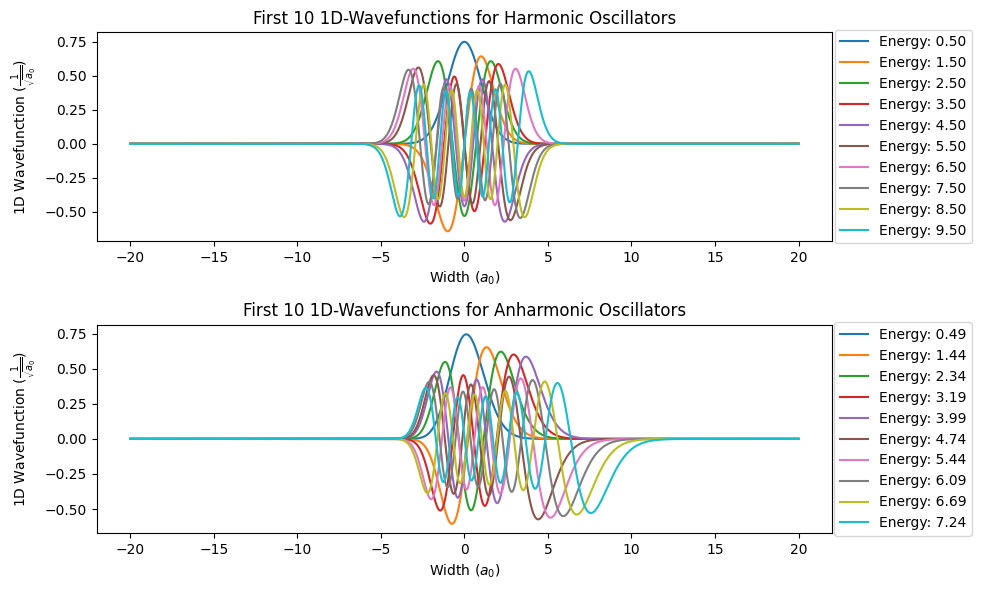

In [59]:
fig, ax = plt.subplots(2)
fig.set_size_inches(10,6)
plot_wf(ax[0], first_10_harmonic, space, "First 10 1D-Wavefunctions for Harmonic Oscillators")
plot_wf(ax[1], first_10_anharmonic, space, "First 10 1D-Wavefunctions for Anharmonic Oscillators")
fig.tight_layout()
fig.savefig("homework-2-grad/first_10_wavefunctions.png", dpi=200, bbox_inches='tight')